<a href="https://colab.research.google.com/github/romellfudi/bills_tf_android/blob/master/cnn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title CNN Prediction
%load_ext watermark
%watermark -a "Romell D.Z." -u -d -p tensorflow,keras

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Romell D.Z. 
last updated: 2020-10-02 

tensorflow 2.3.0
keras 2.4.3


In [ ]:
#@title run
%%capture
!rm -rf bills_photos/ __MACOSX/
!curl -vLJO -H 'Accept: application/octet-stream' https://api.github.com/repos/romellfudi/bills_tf_android/releases/assets/26118074  -u "contactboosttag:254aa92f4c88b57bdbc42070fbd0c66e58d00121" 
!unzip bills_photos.zip
!find . -name '*.xml' -delete
%cd /content/

In [ ]:
#@title Load libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
#@title Split Dataset
# Organize data into train, valid, test dirs
os.chdir('bills_photos')
if os.path.isdir('train/10') is False:
    os.makedirs('train/10')
    os.makedirs('train/20')
    os.makedirs('train/50')
    os.makedirs('train/100')
    os.makedirs('valid/10')
    os.makedirs('valid/20')
    os.makedirs('valid/50')
    os.makedirs('valid/100')
    os.makedirs('test/10')
    os.makedirs('test/20')
    os.makedirs('test/50')
    os.makedirs('test/100')

    for i in random.sample(glob.glob('Billetes 10/*.JPG'), 120):
        shutil.move(i, 'train/10')      
    for i in random.sample(glob.glob('Billetes 20/*.JPG'), 120):
        shutil.move(i, 'train/20')   
    for i in random.sample(glob.glob('Billetes 50/*.JPG'), 120):
        shutil.move(i, 'train/50')   
    for i in random.sample(glob.glob('Billetes 100/*.JPG'), 120):
        shutil.move(i, 'train/100')
    for i in random.sample(glob.glob('Billetes 10/*.JPG'), 60):
        shutil.move(i, 'valid/10')   
    for i in random.sample(glob.glob('Billetes 20/*.JPG'), 60):
        shutil.move(i, 'valid/20')   
    for i in random.sample(glob.glob('Billetes 50/*.JPG'), 60):
        shutil.move(i, 'valid/50')        
    for i in random.sample(glob.glob('Billetes 100/*.JPG'), 60):
        shutil.move(i, 'valid/100')
    for i in random.sample(glob.glob('Billetes 10/*.JPG'), 20):
        shutil.move(i, 'test/10')  
    for i in random.sample(glob.glob('Billetes 20/*.JPG'), 20):
        shutil.move(i, 'test/20')  
    for i in random.sample(glob.glob('Billetes 50/*.JPG'), 20):
        shutil.move(i, 'test/50')      
    for i in random.sample(glob.glob('Billetes 100/*.JPG'), 20):
        shutil.move(i, 'test/100')

os.chdir('../')

In [ ]:
#@title Show cores
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [ ]:
#@title
train_path = 'bills_photos/train'
valid_path = 'bills_photos/valid'
test_path = 'bills_photos/test'

In [ ]:
#@title
# preprocessing_function=tf.keras.applications.vgg16.preprocess_input

In [ ]:
#@title
train_batches = ImageDataGenerator(rotation_range=90) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['10', '20', '50', '100'], batch_size=10)
valid_batches = ImageDataGenerator(rotation_range=90) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['10', '20', '50', '100'], batch_size=10)
test_batches = ImageDataGenerator(rotation_range=90) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['10', '20', '50', '100'], batch_size=10, shuffle=False)

Found 480 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [ ]:
#@title
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

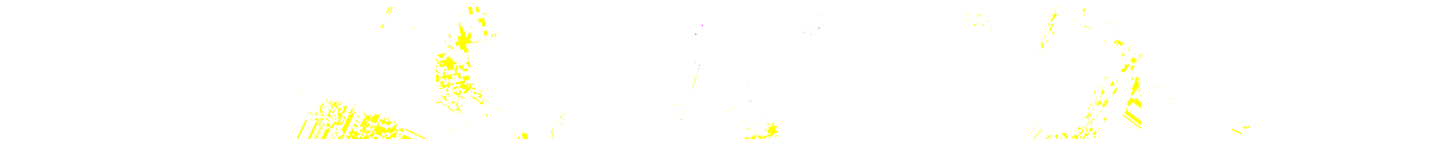

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


In [ ]:
#@title
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(imgs)
print(labels)

In [ ]:
#@title
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=4, activation='softmax')
])

In [ ]:
#@title
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 4)                 802820    
Total params: 822,212
Trainable params: 822,212
Non-trainable params: 0
__________________________________________________

In [ ]:
#@title
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#@title
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
48/48 - 10s - loss: 25.6626 - accuracy: 0.4250 - val_loss: 5.8554 - val_accuracy: 0.5625
Epoch 2/10
48/48 - 9s - loss: 3.8598 - accuracy: 0.6708 - val_loss: 4.3922 - val_accuracy: 0.6500
Epoch 3/10
48/48 - 9s - loss: 2.0532 - accuracy: 0.7667 - val_loss: 1.9255 - val_accuracy: 0.7125
Epoch 4/10
48/48 - 9s - loss: 1.1103 - accuracy: 0.8208 - val_loss: 2.0513 - val_accuracy: 0.7625
Epoch 5/10
48/48 - 9s - loss: 0.9497 - accuracy: 0.8604 - val_loss: 1.7531 - val_accuracy: 0.7958
Epoch 6/10
48/48 - 9s - loss: 1.2192 - accuracy: 0.8313 - val_loss: 2.5260 - val_accuracy: 0.7833
Epoch 7/10
48/48 - 9s - loss: 0.8435 - accuracy: 0.8792 - val_loss: 0.9978 - val_accuracy: 0.8542
Epoch 8/10
48/48 - 9s - loss: 0.5868 - accuracy: 0.8938 - val_loss: 1.6589 - val_accuracy: 0.8167
Epoch 9/10
48/48 - 9s - loss: 0.5001 - accuracy: 0.9042 - val_loss: 1.0856 - val_accuracy: 0.8417
Epoch 10/10
48/48 - 9s - loss: 0.5727 - accuracy: 0.9125 - val_loss: 1.3343 - val_accuracy: 0.8208


In [ ]:
#@title
test_imgs, test_labels = next(test_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

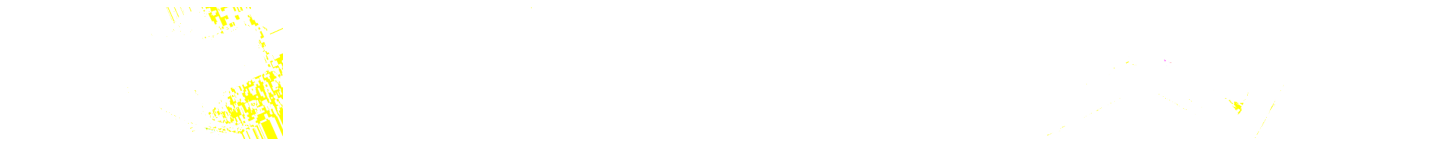

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [ ]:
#@title
plotImages(test_imgs)
print(test_labels)

In [ ]:
#@title
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [ ]:
#@title
np.round(predictions)

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],


In [ ]:
#@title
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
#@title
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#@title
test_batches.class_indices

{'10': 0, '100': 3, '20': 1, '50': 2}

In [ ]:
#@title
result = model.evaluate(x=test_batches)
print(dict(zip(model.metrics_names, result)))

8/8 [==============================] - 1s 116ms/step - loss: 1.4037 - accuracy: 0.7875
{'loss': 1.4036929607391357, 'accuracy': 0.7875000238418579}


Confusion matrix, without normalization
[[19  1  0  0]
 [ 0 20  0  0]
 [ 1  6 13  0]
 [ 3  0  0 17]]


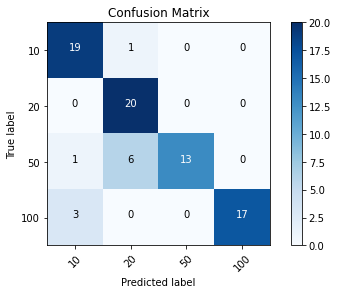

In [ ]:
#@title
cm_plot_labels = ['10','20','50','100']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
#@title
model.save('image_generation_model.h5')
from google.colab import files
!du -sh image_generation_model.h5
files.download('image_generation_model.h5')

9.5M	keras_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title
